# Classification problem on the Twenty News Groups dataset

In this exercise, we'll apply <i>[feature hashing](https://en.wikipedia.org/wiki/Feature_hashing)</i> to create a lower dimensional feature vector of the emails in the <i>twenty newsgroups</i> dataset and build a classifier to identify emails belonging to <i>computer related topics</i> and those which aren't.

More information on the <i>Twenty Newsgroups</i> dataset can be found on the [UCI website](http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html)

## Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [3]:
%run '00_database_connectivity_setup.ipynb'
%matplotlib inline
from IPython.display import display

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

## 1. Create your schema

In [ ]:
sql = """
    create schema YOUR_SCHEMA;
"""
psql.execute(sql, conn)
conn.commit()

## 2. Load the Twenty News Groups dataset into a database table

In [12]:
sql = """
    -- Define external table to fetch data from HDFS
    drop external table if exists YOUR_SCHEMA.twenty_news_groups_ext cascade;
    create external table YOUR_SCHEMA.twenty_news_groups_ext
    (
        doc_id int,
        contents text,
        label text
    ) location ('pxf://hdm1.gphd.local:50070/user/vatsan/dstraining/twenty_news_groups_processed.tsv?profile=hdfstextsimple') 
    format 'CSV' (DELIMITER = E'\t');

    -- create an internal table
    drop table if exists YOUR_SCHEMA.twenty_news_groups cascade;
    create table YOUR_SCHEMA.twenty_news_groups
    as
    (
        select 
            *
        from
            YOUR_SCHEMA.twenty_news_groups_ext
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

In [3]:
sql = """
    select 
        *
    from
       YOUR_SCHEMA.twenty_news_groups
    order by random()
    limit 10
"""
df = psql.read_sql(sql, conn)
df.head()

,doc_id,contents,label
0,7370,From: sandvik@newton.apple.com (Kent Sandvik)\...,talk.religion.misc
1,3931,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,rec.sport.hockey
2,16869,From: simon@giaeb.cc.monash.edu.au\nSubject: S...,soc.religion.christian
3,7471,From: emarsh@hernes-sun.Eng.Sun.COM (Eric Mars...,talk.religion.misc
4,1318,From: edm@wrs.com (Ed McClanahan)\nSubject: Re...,comp.sys.ibm.pc.hardware


## 3. Define UDF for <i>feature hashing</i> (Hashing Vectorizer)

In [4]:
sql = """
    -- Define UDF to use hashing trick to return a feature vector for each document
    -- in the lower dimensional space
    drop function if exists YOUR_SCHEMA.hashing_vectorizer(
        text[],
        int
    );
    create or replace function YOUR_SCHEMA.hashing_vectorizer(
        doc_contents text[],
        num_bits int
    )
    returns float8[]
    as 
    $$
        from sklearn.utils import murmurhash3_32
        import numpy as np
        #The length of the hashed vector is typically chosen as a power of 2
        #for fast computation using bitshifting
        #The dimensionality of hashed vector = 2**num_bits
        hashing_vector = np.zeros(1 << num_bits)
        for w in doc_contents:
            hashed_w = murmurhash3_32(w)
            #We map the hashed value into an index between 0 to 2**(num_bits)
            index_in_vect = hashed_w & ((1 << num_bits)-1)
            #Based on Weinberger et. al http://arxiv.org/pdf/0902.2206.pdf
            #to ensure hash-collisions cancel out the counts
            sign = (hashed_w >= 0)*2.0 - 1.0
            hashing_vector[index_in_vect] += sign
        return hashing_vector
    $$ language plpythonu;
"""
psql.execute(sql, conn)
conn.commit()

## 4. Invoke the hashing vectorizer UDF to create a lower dimensional feature vector of the documents  

In [6]:
def create_hashing_vector_sql(num_bits):
    """
        Return SQL code to create a hashed vector representation of documents
    """
    sql = """
        -- Hashing vector feature representation
        drop table if exists YOUR_SCHEMA.twenty_news_groups_hashing_vector cascade;
        create table YOUR_SCHEMA.twenty_news_groups_hashing_vector
        as
        (
            select
                doc_id,
                YOUR_SCHEMA.hashing_vectorizer(
                    array_agg(token order by token),
                    -- num_bits = 6 => size of feature vector = 2^6 = 64
                    {num_bits}
                ) as feature_vector,
                max(label) as label
            from
            (
                select
                    *
                from
                (
                    select
                        doc_id,
                        regexp_split_to_table(
                            --convert to lower case
                            --replace newlines/carriage returns to space
                            regexp_replace(lower(contents), E'\\r|\\n', ' ', 'g'), 
                            E'\\\s+'        
                        ) as token,
                        -- to create a binary classification problem
                        -- consider the task as being able to predict if a document is related to computers or not            
                        case 
                            when label ~* 'comp.*' then 1 
                            else 0
                        end as label    
                    from
                        YOUR_SCHEMA.twenty_news_groups
                )q1
                where
                    --Remove stopwords
                    token not in (
                        'a\\'s','able','about','above','according','accordingly','across','actually','after','afterwards','again','against','ain\\'t',
                        'all','allow','allows','almost','alone','along','already','also','although','always','am','among','amongst','an','and',
                        'another','any','anybody','anyhow','anyone','anything','anyway','anyways','anywhere','apart','appear','appreciate',
                        'appropriate','are','aren\\'t','around','as','aside','ask','asking','associated','at','available','away','awfully',
                        'be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','believe','below',
                        'beside','besides','best','better','between','beyond','both','brief','but','by','c\\'mon','c\\'s','came','can','can\\'t',
                        'cannot','cant','cause','causes','certain','certainly','changes','clearly','co','com','come','comes','concerning','consequently',
                        'consider','considering','contain','containing','contains','corresponding','could','couldn\\'t','course','currently','definitely',
                        'described','despite','did','didn\\'t','different','do','does','doesn\\'t','doing','don\\'t','done','down','downwards','during',
                        'each','edu','eg','eight','either','else','elsewhere','enough','entirely','especially','et','etc','even','ever','every',
                        'everybody','everyone','everything','everywhere','ex','exactly','example','except','far','few','fifth','first','five',
                        'followed','following','follows','for','former','formerly','forth','four','from','further','furthermore','get','gets',
                        'getting','given','gives','go','goes','going','gone','got','gotten','greetings','had','hadn\\'t','happens','hardly','has',
                        'hasn\\'t','have','haven\\'t','having','he','he\\'s','hello','help','hence','her','here','here\\'s','hereafter','hereby','herein',
                        'hereupon','hers','herself','hi','him','himself','his','hither','hopefully','how','howbeit','however','i\\'d','i\\'ll','i\\'m',
                        'i\\'ve','ie','if','ignored','immediate','in','inasmuch','inc','indeed','indicate','indicated','indicates','inner','insofar',
                        'instead','into','inward','is','isn\\'t','it','it\\'d','it\\'ll','it\\'s','its','itself','just','keep','keeps','kept','know','knows',
                        'known','last','lately','later','latter','latterly','least','less','lest','let','let\\'s','like','liked','likely','little','look',
                        'looking','looks','ltd','mainly','many','may','maybe','me','mean','meanwhile','merely','might','more','moreover','most','mostly',
                        'much','must','my','myself','name','namely','nd','near','nearly','necessary','need','needs','neither','never','nevertheless','new',
                        'next','nine','no','nobody','non','none','noone','nor','normally','not','nothing','novel','now','nowhere','obviously','of','off',
                        'often','oh','ok','okay','old','on','once','one','ones','only','onto','or','other','others','otherwise','ought','our','ours',
                        'ourselves','out','outside','over','overall','own','particular','particularly','per','perhaps','placed','please','plus','possible',
                        'presumably','probably','provides','que','quite','qv','rather','rd','re','really','reasonably','regarding','regardless','regards',
                        'relatively','respectively','right','said','same','saw','say','saying','says','second','secondly','see','seeing','seem','seemed',
                        'seeming','seems','seen','self','selves','sensible','sent','serious','seriously','seven','several','shall','she','should',
                        'shouldn\\'t','since','six','so','some','somebody','somehow','someone','something','sometime','sometimes','somewhat','somewhere',
                        'soon','sorry','specified','specify','specifying','still','sub','such','sup','sure','t\\'s','take','taken','tell','tends','th',
                        'than','thank','thanks','thanx','that','that\\'s','thats','the','their','theirs','them','themselves','then','thence','there',
                        'there\\'s','thereafter','thereby','therefore','therein','theres','thereupon','these','they','they\\'d','they\\'ll','they\\'re',
                        'they\\'ve','think','third','this','thorough','thoroughly','those','though','three','through','throughout','thru','thus','to',
                        'together','too','took','toward','towards','tried','tries','truly','try','trying','twice','two','un','under','unfortunately',
                        'unless','unlikely','until','unto','up','upon','us','use','used','useful','uses','using','usually','value','various','very',
                        'via','viz','vs','want','wants','was','wasn\\'t','way','we','we\\'d','we\\'ll','we\\'re','we\\'ve','welcome','well','went','were',
                        'weren\\'t','what','what\\'s','whatever','when','whence','whenever','where','where\\'s','whereafter','whereas','whereby','wherein',
                        'whereupon','wherever','whether','which','while','whither','who','who\\'s','whoever','whole','whom','whose','why','will',
                        'willing','wish','with','within','without','won\\'t','wonder','would','would','wouldn\\'t','yes','yet','you','you\\'d','you\\'ll',
                        'you\\'re','you\\'ve','your','yours','yourself','yourselves','zero'
                    )
            )q2
            group by doc_id
        ) distributed randomly;
    """.format(
        num_bits=num_bits
    )
    return sql

In [6]:
num_bits = 6
psql.execute(create_hashing_vector_sql(num_bits), conn)
conn.commit()

## 5. Create train & test split    

In [7]:
def create_train_test_split_sql():
    """
        Return SQL code for creating train and test split
    """
    sql = """
        -- Set the seed to ensure the random splits are repeatable
        -- This is important if you want to measure performance 
        -- of classifiers based by varying the "num_bits" parameter
        -- Note: You should run the setseed() statement and the following create temp table statement as a single
        -- transaction.
        select setseed(0.5);
        drop table if exists hashing_vector_train_test_split cascade;
        create temp table hashing_vector_train_test_split
        as
        (
            select
                doc_id,
                feature_vector,
                label,
                random() as splitter
            from
                YOUR_SCHEMA.twenty_news_groups_hashing_vector
            order by
                doc_id
        ) distributed randomly;

        -- Training set
        drop table if exists YOUR_SCHEMA.hashing_vector_training_set cascade;
        create table YOUR_SCHEMA.hashing_vector_training_set
        as
        (
            select 
                doc_id,
                feature_vector,
                label
            from
                hashing_vector_train_test_split
            where 
                splitter <= 0.75
        ) distributed randomly;

        -- Test set
        drop table if exists YOUR_SCHEMA.hashing_vector_test_set cascade;
        create table YOUR_SCHEMA.hashing_vector_test_set
        as
        (
            select 
                doc_id,
                feature_vector,
                label
            from
                hashing_vector_train_test_split
            where 
                splitter > 0.75
        ) distributed randomly; 
    """
    return sql

In [8]:
psql.execute(create_train_test_split_sql(), conn)
conn.commit()

## 6. Train Classifier

In [8]:
def train_classifier_sql():
    """
        Return SQL for training the classifier
    """
    sql = """
        drop table if exists YOUR_SCHEMA.hashing_vector_logregr_mdl;
        drop table if exists YOUR_SCHEMA.hashing_vector_logregr_mdl_summary;
        select 
            madlib.logregr_train( 
                'YOUR_SCHEMA.hashing_vector_training_set',
                'YOUR_SCHEMA.hashing_vector_logregr_mdl',
                'label',
                'feature_vector',
                NULL,
                20,
                'irls'
        );
    """
    return sql

In [10]:
psql.execute(train_classifier_sql(), conn)
conn.commit()

## 7. Score using the trained classifier 

In [9]:
def score_classifier_sql():
    """
        Return SQL code to score using the trained classifier
    """
    sql = """
        drop table if exists YOUR_SCHEMA.hashing_vector_prediction_results cascade;
        create table YOUR_SCHEMA.hashing_vector_prediction_results
        as
        (
            select
                doc_id,
                label as actual_label,
                madlib.logregr_predict(
                    coef,
                    feature_vector
                ) as predicted_label,            
                madlib.logregr_predict_prob(
                    coef,
                    feature_vector
                ) as predicted_label_proba
            from
                YOUR_SCHEMA.hashing_vector_logregr_mdl mdl,
                YOUR_SCHEMA.hashing_vector_test_set test_set
        ) distributed randomly;
    """
    return sql

In [12]:
psql.execute(score_classifier_sql(), conn)
conn.commit()

## 8. Test ROC

In [13]:
sql = """
    select
        doc_id,
        actual_label,
        predicted_label,
        predicted_label_proba
    from
        YOUR_SCHEMA.hashing_vector_prediction_results
"""
df = psql.read_sql(sql, conn)
df.head()

,doc_id,actual_label,predicted_label,predicted_label_proba
0,11937,0,False,0.269493
1,10631,1,False,0.351043
2,9454,1,False,0.201282
3,16881,0,False,0.282181
4,10145,1,False,0.180679


In [10]:
def plot_roc(num_bits):
    """
        Show the ROC curve for the prediction results from the model
    """
    sql = """
        select
            doc_id,
            actual_label,
            predicted_label,
            predicted_label_proba
        from
            YOUR_SCHEMA.hashing_vector_prediction_results
    """
    df = psql.read_sql(sql, conn)
    from sklearn import metrics
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    fpr, tpr, thresholds = metrics.roc_curve(
                                df['actual_label'].tolist(),
                                df['predicted_label_proba'].tolist(), 
                                pos_label=1
                            )
    auc = metrics.auc(fpr, tpr)
    rocdf = pd.DataFrame(np.transpose([fpr, tpr, thresholds]), columns = ['fpr','tpr','thresholds'])
    rocdf.plot(x='fpr',y='tpr', label='AUC:{0}'.format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic regression model on hashed vector of size {0}, AUC: {1}'.format(1<<num_bits, auc))
    plt.show()

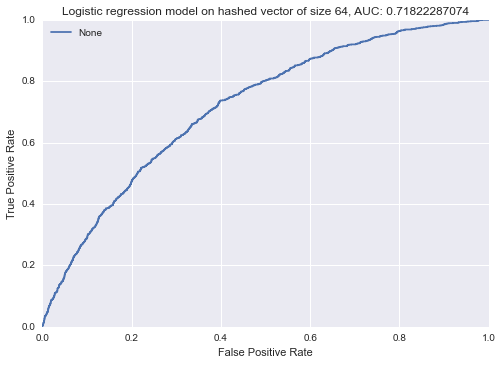

In [15]:
plot_roc(num_bits)

## 9. Increase num_bits and measure effect on classification accuracy

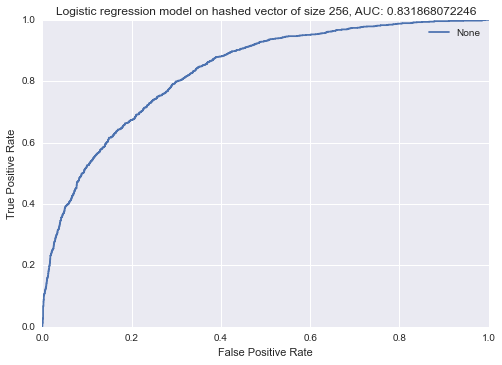

In [16]:
num_bits = 8
psql.execute(create_hashing_vector_sql(num_bits), conn)
psql.execute(create_train_test_split_sql(), conn)
psql.execute(train_classifier_sql(), conn)
psql.execute(score_classifier_sql(), conn)
plot_roc(num_bits)
conn.commit()

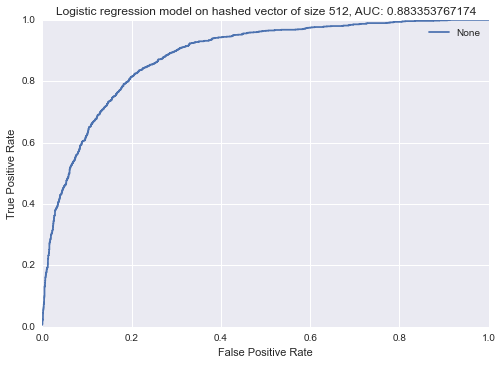

In [79]:
num_bits = 9
psql.execute(create_hashing_vector_sql(num_bits), conn)
psql.execute(create_train_test_split_sql(), conn)
psql.execute(train_classifier_sql(), conn)
psql.execute(score_classifier_sql(), conn)
plot_roc(num_bits)
conn.commit()

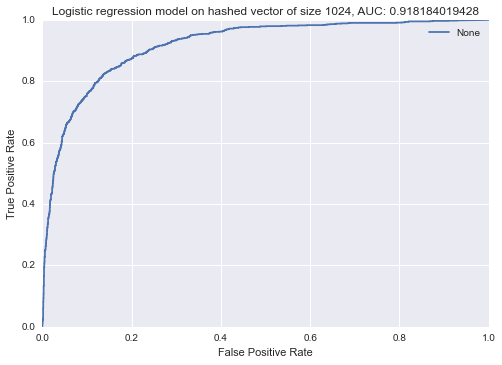

In [80]:
num_bits = 10
psql.execute(create_hashing_vector_sql(num_bits), conn)
psql.execute(create_train_test_split_sql(), conn)
psql.execute(train_classifier_sql(), conn)
psql.execute(score_classifier_sql(), conn)
plot_roc(num_bits)
conn.commit()

### Use 2-skip-bigrams to create your feature vector

In [11]:
def create_hashing_vector_sql_skipgrams(num_bits):
    """
        Return SQL code to create a hashed vector representation of documents
    """
    sql = """
    
        --1) Create unigrams table
        drop table if exists unigrams;
        create temp table unigrams
        as
        (
            select
                doc_id,
                regexp_split_to_array(
                    --convert to lower case
                    --replace newlines/carriage returns to space
                    regexp_replace(lower(contents), E'\\r|\\n', ' ', 'g'), 
                    E'\\\s+'        
                ) as token_arr,
                -- to create a binary classification problem
                -- consider the task as being able to predict if a document is related to computers or not            
                case 
                    when label ~* 'comp.*' then 1 
                    else 0
                end as label    
            from
                YOUR_SCHEMA.twenty_news_groups
        );    
        
        --2) Hashing vector feature representation
        drop table if exists YOUR_SCHEMA.twenty_news_groups_hashing_vector cascade;
        create table YOUR_SCHEMA.twenty_news_groups_hashing_vector
        as
        (
            select
                doc_id,
                YOUR_SCHEMA.hashing_vectorizer(
                    array_agg(token order by token),
                    -- num_bits = 6 => size of feature vector = 2^6 = 64
                    {num_bits}
                ) as feature_vector,
                max(label) as label
            from
            (
                select
                    *
                from
                (
                    select
                        doc_id,
                        -- concatenate bigrams into a single word, with space as delimiter
                        array_to_string(
                            -- Generate 2-skip-bigrams
                            YOUR_SCHEMA.generate_k_skip_n_grams(
                                token_arr,
                                2, --no. of skips (k)
                                2  --n-gram (n=2 => bigram, n=3 => trigram etc.) 
                            ),
                            ' '
                        ) as token,
                        label
                    from
                        unigrams
                    union all
                    select 
                        doc_id,
                        unnest(token_arr) as token,
                        label
                    from unigrams
                )q1
                where
                    --Remove stopwords
                    token not in (
                        'a\\'s','able','about','above','according','accordingly','across','actually','after','afterwards','again','against','ain\\'t',
                        'all','allow','allows','almost','alone','along','already','also','although','always','am','among','amongst','an','and',
                        'another','any','anybody','anyhow','anyone','anything','anyway','anyways','anywhere','apart','appear','appreciate',
                        'appropriate','are','aren\\'t','around','as','aside','ask','asking','associated','at','available','away','awfully',
                        'be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','believe','below',
                        'beside','besides','best','better','between','beyond','both','brief','but','by','c\\'mon','c\\'s','came','can','can\\'t',
                        'cannot','cant','cause','causes','certain','certainly','changes','clearly','co','com','come','comes','concerning','consequently',
                        'consider','considering','contain','containing','contains','corresponding','could','couldn\\'t','course','currently','definitely',
                        'described','despite','did','didn\\'t','different','do','does','doesn\\'t','doing','don\\'t','done','down','downwards','during',
                        'each','edu','eg','eight','either','else','elsewhere','enough','entirely','especially','et','etc','even','ever','every',
                        'everybody','everyone','everything','everywhere','ex','exactly','example','except','far','few','fifth','first','five',
                        'followed','following','follows','for','former','formerly','forth','four','from','further','furthermore','get','gets',
                        'getting','given','gives','go','goes','going','gone','got','gotten','greetings','had','hadn\\'t','happens','hardly','has',
                        'hasn\\'t','have','haven\\'t','having','he','he\\'s','hello','help','hence','her','here','here\\'s','hereafter','hereby','herein',
                        'hereupon','hers','herself','hi','him','himself','his','hither','hopefully','how','howbeit','however','i\\'d','i\\'ll','i\\'m',
                        'i\\'ve','ie','if','ignored','immediate','in','inasmuch','inc','indeed','indicate','indicated','indicates','inner','insofar',
                        'instead','into','inward','is','isn\\'t','it','it\\'d','it\\'ll','it\\'s','its','itself','just','keep','keeps','kept','know','knows',
                        'known','last','lately','later','latter','latterly','least','less','lest','let','let\\'s','like','liked','likely','little','look',
                        'looking','looks','ltd','mainly','many','may','maybe','me','mean','meanwhile','merely','might','more','moreover','most','mostly',
                        'much','must','my','myself','name','namely','nd','near','nearly','necessary','need','needs','neither','never','nevertheless','new',
                        'next','nine','no','nobody','non','none','noone','nor','normally','not','nothing','novel','now','nowhere','obviously','of','off',
                        'often','oh','ok','okay','old','on','once','one','ones','only','onto','or','other','others','otherwise','ought','our','ours',
                        'ourselves','out','outside','over','overall','own','particular','particularly','per','perhaps','placed','please','plus','possible',
                        'presumably','probably','provides','que','quite','qv','rather','rd','re','really','reasonably','regarding','regardless','regards',
                        'relatively','respectively','right','said','same','saw','say','saying','says','second','secondly','see','seeing','seem','seemed',
                        'seeming','seems','seen','self','selves','sensible','sent','serious','seriously','seven','several','shall','she','should',
                        'shouldn\\'t','since','six','so','some','somebody','somehow','someone','something','sometime','sometimes','somewhat','somewhere',
                        'soon','sorry','specified','specify','specifying','still','sub','such','sup','sure','t\\'s','take','taken','tell','tends','th',
                        'than','thank','thanks','thanx','that','that\\'s','thats','the','their','theirs','them','themselves','then','thence','there',
                        'there\\'s','thereafter','thereby','therefore','therein','theres','thereupon','these','they','they\\'d','they\\'ll','they\\'re',
                        'they\\'ve','think','third','this','thorough','thoroughly','those','though','three','through','throughout','thru','thus','to',
                        'together','too','took','toward','towards','tried','tries','truly','try','trying','twice','two','un','under','unfortunately',
                        'unless','unlikely','until','unto','up','upon','us','use','used','useful','uses','using','usually','value','various','very',
                        'via','viz','vs','want','wants','was','wasn\\'t','way','we','we\\'d','we\\'ll','we\\'re','we\\'ve','welcome','well','went','were',
                        'weren\\'t','what','what\\'s','whatever','when','whence','whenever','where','where\\'s','whereafter','whereas','whereby','wherein',
                        'whereupon','wherever','whether','which','while','whither','who','who\\'s','whoever','whole','whom','whose','why','will',
                        'willing','wish','with','within','without','won\\'t','wonder','would','would','wouldn\\'t','yes','yet','you','you\\'d','you\\'ll',
                        'you\\'re','you\\'ve','your','yours','yourself','yourselves','zero'
                    )
            )q2
            group by doc_id
        ) distributed randomly;
    """.format(
        num_bits=num_bits
    )
    return sql

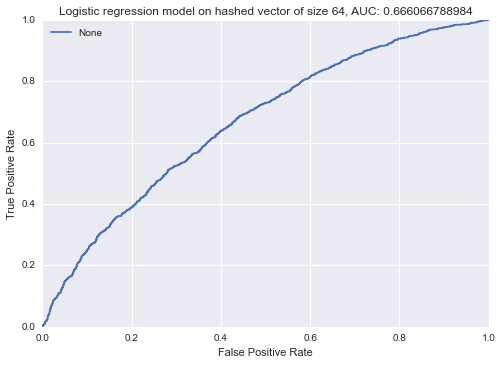

In [13]:
num_bits = 6
psql.execute(create_hashing_vector_sql_skipgrams(num_bits), conn)
psql.execute(create_train_test_split_sql(), conn)
psql.execute(train_classifier_sql(), conn)
psql.execute(score_classifier_sql(), conn)
plot_roc(num_bits)
conn.commit()

As you can see above, the accuracy of the models that includes 2-skip-bigrams along with all unigrams performed poorer than the models which included unigrams alone. This is likely because of the increased number of collisions introduced by more tokens, without a corresponding increase in the number of bits for the hashed feature vector. If we increase the size of the output vector, we may be able to see performance gains.